## Velora - Perhitungan Kalori dan Rekomendasi Makanan

3 Paper/studi terkait perhitungan kalori harian:
1. Persamaan Mifflin-St Jeor, [Paper Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC7478086/)
2. Rekomendasi koreksi faktor klinis, [Paper Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC6068274/)


#### Import Library

In [ ]:
# Install library/packages
!pip install tensorflow tensorflowjs pandas

In [2]:
# Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import random

#### Load Dataset

In [3]:
# url google sheets (dataset)
sheet_url = "https://docs.google.com/spreadsheets/d/1XsQ7G0yBhPkCHSMAziD8RWpr5IEcTquvDBMmjdT0ZtM/edit?usp=sharing"

# Load data
csv_url = sheet_url.replace("/edit?usp=sharing", "/export?format=csv")
data = pd.read_csv(csv_url)

In [4]:
display(data.head(15))

,id_makanan,calories,proteins,fat,carbohydrate,name,label
0,1,280.0,9.2,28.4,0.0,Abon,"breakfast, lunch, dinner"
1,2,513.0,23.7,37.0,21.3,Abon Ikan Gabus,"breakfast, lunch, dinner"
2,3,0.0,0.0,0.2,0.0,Agar-Agar,snack
3,4,85.0,0.9,6.5,7.7,Buah Alpukat,"snack, breakfast"
4,5,184.0,18.8,14.0,0.0,Daging Sapi Muda (Dengan Lemak),"breakfast, lunch, dinner"
5,6,174.0,19.6,10.0,0.0,Daging Sapi Muda (Tanpa Lemak),"breakfast, lunch, dinner"
6,7,190.0,19.1,12.0,0.0,Daging Sapi Muda,"breakfast, lunch, dinner"
7,8,30.0,0.5,0.2,6.8,Anggur Hijau,snack
8,9,354.0,16.4,31.5,0.0,Daging Angsa,"lunch, dinner"
9,10,126.0,3.4,7.9,10.3,Anyang Sayur,"breakfast, lunch"


In [5]:
label_menu = ['breakfast', 'lunch', 'dinner', 'snack']

# Jumlah item per kategori
print("Jumlah Item per Kategori:")
for label in label_menu:
    count = data['label'].str.contains(label, na=False).sum()
    print(f"- {label.capitalize()}: {count} item")

Jumlah Item per Kategori:
- Breakfast: 330 item
- Lunch: 460 item
- Dinner: 462 item
- Snack: 331 item


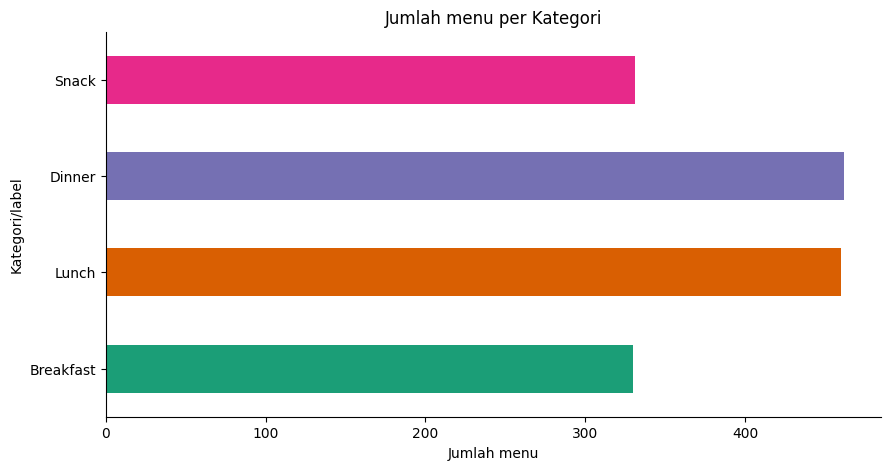

In [6]:
label_menu = ['breakfast', 'lunch', 'dinner', 'snack']
label_counts = {}

# jumlah item per kategori pada label makanan
for label in label_menu:
    count = data['label'].str.contains(label, na=False).sum()

    # capitalized label sebagai key
    label_counts[label.capitalize()] = count

counts_series = pd.Series(label_counts)

plt.figure(figsize=(10, 5))
counts_series.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Jumlah menu per Kategori')
plt.xlabel('Jumlah menu')
plt.ylabel('Kategori/label')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

In [7]:
# Data validation
data = data.dropna(subset=["calories", "proteins", "fat", "carbohydrate", "name", "label"])
data = data.reset_index(drop=True)

#### Hitung Kalori Harian (TDEE)

In [8]:
# Hitung REE dengan rumus Mifflin-St Jeor
def calc_ree(age, sex, height, weight):
    return (10 * weight + 6.25 * height - 5 * age + (5 if sex == "laki-laki" else -161))

In [9]:
# Get activity factor
def get_activity_factor(activity, exercise):
    levels = {
        "rendah": {"tidak pernah": 1.2, "jarang": 1.3},
        "sedang": {"jarang": 1.375, "sering": 1.45},
        "tinggi": {"jarang": 1.55, "sering": 1.6}
    }
    return levels.get(activity, {}).get(exercise, 1.2)

In [10]:
# Calculate TDEE
def calc_tdee(age, sex, height, weight, activity, exercise, goal, target_weight):
    ree = calc_ree(age, sex, height, weight)
    factor = get_activity_factor(activity, exercise)
    tdee = ree * factor
    if goal == "Menurunkan Berat Badan":
        tdee -= 500
    elif goal == "Meningkatkan Berat Badan":
        tdee += 500
    return max(int(tdee), 1000)   # agar tidak negatif

#### Split TDEE Menjadi 4 Kategori Makanan

In [11]:
# Split TDEE menjadi 4 Kategori Makanan
def split_tdee(tdee):
    return {
        "breakfast": int(tdee * 0.25),  # Breakfast (0.25)
        "lunch": int(tdee * 0.35),      # Lunch (0.35)
        "dinner": int(tdee * 0.30),     # Dinner (0.30)
        "snack": int(tdee * 0.10)       # Snack (0.10)
    }                                   # Total (1.00)

#### Rekomendasi Makanan

In [12]:
# Rekomendasi makanan ≤ slot kalori
# Max per menu yaitu 100-150 gram (diambil dari artikel hallosehat.com)
def recommend_menus(slot, max_calories, max_gram=150, retries=5, exclude_list=None):
    if exclude_list is None:
        exclude_list = []

    label_filter_original = data[data['label'].str.contains(slot)]
    label_filter_original = label_filter_original[label_filter_original['calories'] > 0].copy()

    # Filter menu
    label_filter_original = label_filter_original[~label_filter_original['name'].isin(exclude_list)].copy()


    for attempt in range(retries):
        label_filter = label_filter_original.copy()
        recommended = []
        total_cal = 0
        current_slot_recommended_names = []

        while not label_filter.empty:
            food = label_filter.sample(1).iloc[0]
            food_cal = food["calories"]

            gram_needed = (max_calories - total_cal) / food_cal * 100
            gram = min(gram_needed, max_gram)

            MIN_GRAM = 50
            gram = max(gram, MIN_GRAM)

            total_calories = (food["calories"] * gram) / 100

            # Jika melebihi batas, jangan tambahkan
            if total_cal + total_calories > max_calories:
                # Cek apakah ada sisa calories untuk menu lain
                label_filter = label_filter[label_filter["name"] != food["name"]]
                continue

            item = {
                "name": food["name"],
                "calories": food["calories"],
                "proteins": food["proteins"],
                "fat": food["fat"],
                "carbohydrate": food["carbohydrate"],
                "grams": gram,
                "total_calories": total_calories,
                "total_protein": (food["proteins"] * gram) / 100,
                "total_fat": (food["fat"] * gram) / 100,
                "total_carb": (food["carbohydrate"] * gram) / 100
            }

            total_cal += item["total_calories"]
            recommended.append(item)
            current_slot_recommended_names.append(food["name"]) # Add name to the list

            label_filter = label_filter[label_filter["name"] != food["name"]]

        if total_cal <= max_calories:
            return recommended

    raise ValueError(f"Tidak dapat menemukan kombinasi makanan untuk slot '{slot}' yang tidak melebihi {max_calories}.")

#### Model Inference/input

##### Data User/pengguna

In [13]:
# Contoh data user
# Contoh 10 pertanyaan
user = {
    "age": 22,
    "sex": "laki-laki",
    "height": 160,
    "weight": 50,
    "target_weight": 60,
    "activity": "sedang",
    "exercise": "sering",
    "snack_habit": "sering",
    "sleep": 6,
    "goal": "Meningkatkan Berat Badan"
}

In [20]:
# Hitung TDEE dan slot
tdee = calc_tdee(user["age"], user["sex"], user["height"], user["weight"],
                 user["activity"], user["exercise"], user["goal"], user["target_weight"])
slots = split_tdee(tdee)

# TDEE
display(Markdown(f"Kalori Harian (TDEE): **{tdee} kcal**"))

# Inisialisasi
rekomendasi = {}
recommended_items_across_slots = []

for slot in ["breakfast", "lunch", "dinner", "snack"]:
    limit = slots[slot]

    menu_list = recommend_menus(slot, limit, exclude_list=recommended_items_across_slots)
    rekomendasi[slot] = menu_list

    # filter menu yang muncul
    for item in menu_list:
        recommended_items_across_slots.append(item["name"])

    display(Markdown(f"## {slot.capitalize()}"))
    slot_total = sum(item["total_calories"] for item in menu_list)

    html_content = '<div style="display: flex; flex-wrap: wrap; gap: 24px;">'

    for item in menu_list:
        html_content += f"""
        <div style="width: 220px; border-radius: 10px; border: 1px solid #ddd; padding: 10px;">
            <div style="padding-top: 8px; min-height: 120px;">
                <div><b>{item['name']}</b></div>
                <div>porsi: {item['grams']:.0f} gram</div>
                <div>kalori: {item['total_calories']:.1f} kcal</div>
                <div>protein: {item['total_protein']:.1f} g</div>
                <div>lemak: {item['total_fat']:.1f} g</div>
                <div>karbo: {item['total_carb']:.1f} g</div>
            </div>
        </div>
        """

    html_content += '</div>'
    display(HTML(html_content))
    display(Markdown(f"**Total Kalori untuk {slot.capitalize()}:** {slot_total:.1f} kcal"))

Kalori Harian (TDEE): **2522 kcal**

## Breakfast

**Total Kalori untuk Breakfast:** 630.0 kcal

## Lunch

**Total Kalori untuk Lunch:** 880.5 kcal

## Dinner

**Total Kalori untuk Dinner:** 756.0 kcal

## Snack

**Total Kalori untuk Snack:** 252.0 kcal

#### Konversi ke TF.js Model

In [21]:
x_dummy = []
y_dummy = []

# Mapping (one-hot encoding)
slot_to_onehot = {
    "breakfast": [1, 0, 0, 0],
    "lunch":     [0, 1, 0, 0],
    "dinner":    [0, 0, 1, 0],
    "snack":     [0, 0, 0, 1]
}

for slot, items in rekomendasi.items():
    for item in items:
        # fitur (kalori, protein, lemak, karbohidrat)
        x_dummy.append([item["calories"], item["proteins"], item["fat"], item["carbohydrate"]])
        y_dummy.append(slot_to_onehot[slot])

x_dummy = np.array(x_dummy, dtype=np.float32)
y_dummy = np.array(y_dummy, dtype=np.float32)

In [22]:
# Model rekomendasi
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),              # input layer (kalori, protein, lemak, karbo)
    tf.keras.layers.Dense(8, activation='relu'),    # 8 unit hidden layer dan aktivasi ReLU
    tf.keras.layers.Dense(4, activation='softmax')  # 4 output: breakfast, lunch, dinner, snack
])

model.compile(optimizer='adam', loss='categorical_crossentropy')

In [23]:
# Train dummy (agar bisa disimpan)
model.fit(x_dummy, y_dummy, epochs=3)

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 27.3831
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 26.7127
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 26.0424


In [ ]:
# Simpan ke .h5
model.save("rekomendasi_makan.h5")

In [ ]:
# Konversi ke tfjs
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras rekomendasi_makan.h5 model_tfjs/

In [26]:
# zip model
!zip -r model_tfjs.zip model_tfjs/

  adding: model_tfjs/ (stored 0%)
  adding: model_tfjs/model.json (deflated 72%)
  adding: model_tfjs/group1-shard1of1.bin (stored 0%)


In [27]:
!ls

model_tfjs  model_tfjs.zip  nutrition.csv  rekomendasi_makan.h5  sample_data


#### Evaluasi Precision

In [28]:
# Evaluasi dengan precision
# Apakah makanan sesuai label slot?
def evaluasi(result):
    correct = 0
    total = 0
    for slot, items in result.items():
        for item in items:
            if slot in data[data["name"] == item["name"]]["label"].values[0]:
                correct += 1
            total += 1
    precision = correct / total if total else 0
    return precision

precision = evaluasi(rekomendasi)
display(Markdown(f"Evaluasi (Precision): **{precision:.2f}**"))

Evaluasi (Precision): **1.00**